In [109]:
import os
import time
from watermark import watermark

import numpy as np
import shutil

from nltk.tokenize import wordpunct_tokenize
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from src.preprocessors import OneHotCustomVectorizer
from src.data_utils import load_data
from src.tabular_utils import training_tabular

import shap

SEED = 33
VOCAB_SIZE = 4096
MAX_LEN = 128

LIMIT = 30000

# ===========================================
print(f"[!] Script start time: {time.ctime()}")
TOKENIZER = wordpunct_tokenize

# LOADING DATA
ROOT = "./"
X_train_cmds, y_train, X_test_cmds, y_test, X_train_malicious_cmd, X_train_baseline_cmd, X_test_malicious_cmd, X_test_baseline_cmd = load_data(ROOT, SEED, limit=LIMIT)

# PREPROCESSING
# tokenizer = CommandTokenizer(tokenizer_fn=TOKENIZER, vocab_size=VOCAB_SIZE, max_len=MAX_LEN)
oh = OneHotCustomVectorizer(tokenizer=TOKENIZER, max_features=VOCAB_SIZE)
print("[*] Fitting One-Hot encoder...")
X_train_onehot = oh.fit_transform(X_train_cmds)
X_test_onehot = oh.transform(X_test_cmds)

[!] Script start time: Wed Jan 31 20:10:42 2024
[*] Fitting One-Hot encoder...


# Logistic Regression

In [112]:
log_reg_onehot = LogisticRegression(random_state=SEED)

log_reg_trained = training_tabular(
    model=log_reg_onehot,
    name="log_reg_onehot",
    X_train_encoded=X_train_onehot,
    X_test_encoded=X_test_onehot,
    y_train=y_train,
    y_test=y_test,
    logs_folder="./temp",
    model_file=None
)
shutil.rmtree('./temp')

[*] Training log_reg_onehot model...
[!] log_reg_onehot model scores: train_tpr=1.0000, train_f1=1.0000, train_acc=1.0000, train_auc=1.0000
[!] log_reg_onehot model scores: val_tpr=0.9989, val_f1=0.9995, val_acc=0.9995, val_auc=1.0000


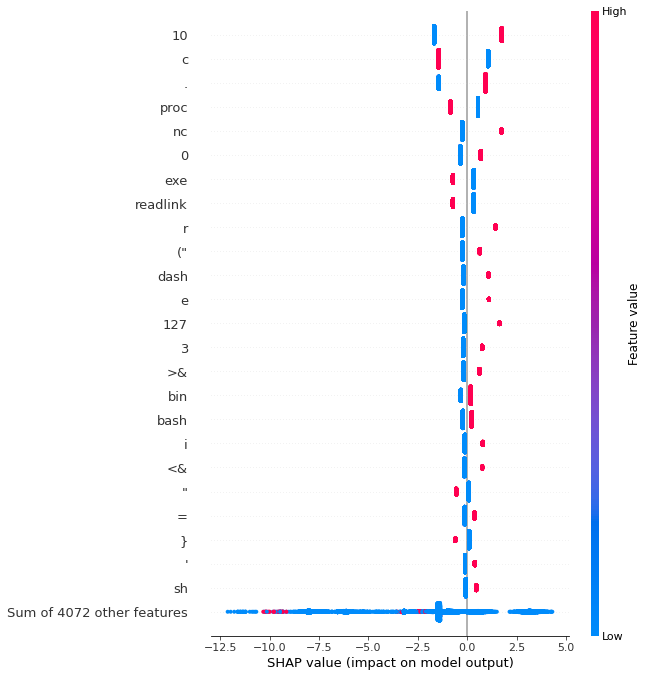

In [113]:
explainer = shap.LinearExplainer(
    log_reg_trained,
    X_train_onehot,
    feature_names=list(oh.vocab.keys())
)
shap_values_logreg = explainer(X_test_onehot)
shap.plots.beeswarm(shap_values_logreg, max_display=25)

In [114]:
# get weights of log reg model
log_reg_weights = log_reg_trained.coef_
vocab = oh.vocab

# find top 10 most important features
TOP_HEAVIEST = 15
top_malicious_idx = np.argsort(log_reg_weights[0])[-TOP_HEAVIEST:][::-1]
top_malicious_features = [list(vocab.keys())[idx] for idx in top_malicious_idx]
print(top_malicious_features)

['10', '.', 'nc', '127', 'r', 'rcat', 'e', 'dash', 'cu', 'eu', '0', '3', 'i', '<&', '("']


In [115]:
TOP_LIGHT = 15
top_benign_idx = np.argsort(log_reg_weights[0])[:TOP_LIGHT]
top_benign_features = [list(vocab.keys())[idx] for idx in top_benign_idx]
print(top_benign_features)

['c', 'proc', 'net', 'internal', 'cloudapp', 'exe', 'readlink', 'var', 'lib', 'w', 'o365ip', 'py', '}', 'etc', '"']


## GBDT

In [116]:
xgb_model_onehot = XGBClassifier(n_estimators=100, max_depth=10, random_state=SEED)

xgb_model_onehot_trained = training_tabular(
    model=xgb_model_onehot,
    name="xgb_model_onehot",
    X_train_encoded=X_train_onehot,
    X_test_encoded=X_test_onehot,
    y_train=y_train,
    y_test=y_test,
    logs_folder="./temp",
    model_file=None
)
shutil.rmtree('./temp')

[*] Training xgb_model_onehot model...
[!] xgb_model_onehot model scores: train_tpr=1.0000, train_f1=1.0000, train_acc=1.0000, train_auc=1.0000
[!] xgb_model_onehot model scores: val_tpr=1.0000, val_f1=0.9999, val_acc=0.9999, val_auc=1.0000


In [117]:
features = list(oh.vocab.keys())

explainer = shap.Explainer(
    xgb_model_onehot_trained,
    feature_names=features
)

explanations = explainer(X_test_onehot)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


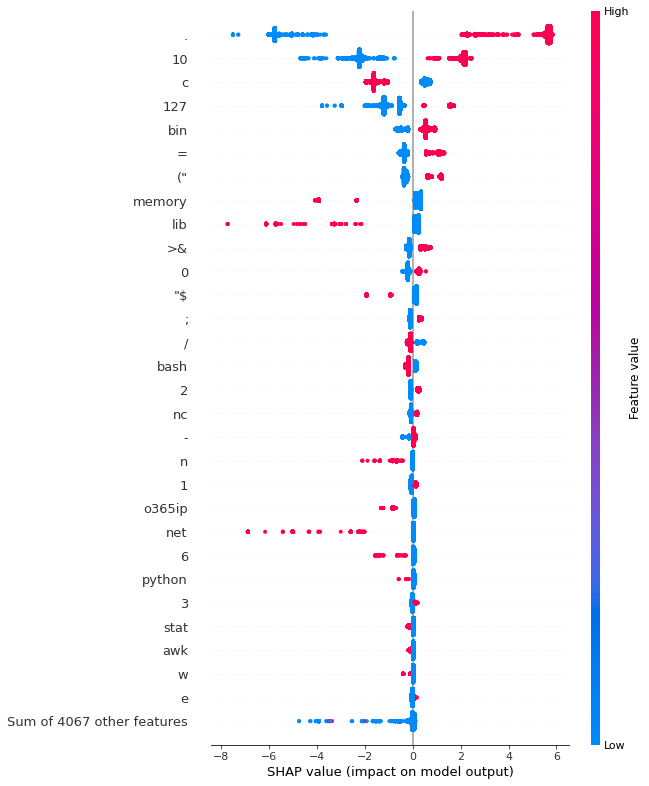

In [134]:
shap.plots.beeswarm(explanations, max_display=30)

In [119]:
mean_shap_values = np.mean(explanations.values, axis=0)
assert len(mean_shap_values) == len(features)

# find top 10 most important features
TOP_HEAVIEST = 15
top_malicious_idx = np.argsort(mean_shap_values)[-TOP_HEAVIEST:][::-1]
top_malicious_features = {features[idx]: round(mean_shap_values[idx], 4) for idx in top_malicious_idx}
print(top_malicious_features)

{'.': 0.7537, 'bin': 0.1829, 'memory': 0.0529, 'python': 0.0414, '2': 0.0315, '6': 0.0288, 'w': 0.021, '-': 0.013, '"$': 0.0109, '54': 0.0049, ');': 0.0029, 'o365ip': 0.0026, 'logger': 0.0018, 'echo': 0.0007, 'py': 0.0006}


In [120]:
TOP_LIGHT = 15
top_benign_idx = np.argsort(mean_shap_values)[:TOP_LIGHT]
top_benign_features = {features[idx]: round(mean_shap_values[idx],4) for idx in top_benign_idx}
print(top_benign_features)

{'127': -0.7015, 'c': -0.5851, '10': -0.3544, '("': -0.0818, 'n': -0.0734, '/': -0.0652, 'lib': -0.0643, '0': -0.0626, 'nc': -0.0435, '=': -0.0404, '>&': -0.0364, 'bash': -0.0235, 'dev': -0.0189, 'e': -0.0173, '3': -0.0171}


# Compare with adversarial training

In [121]:
from sklearn.utils import shuffle

X_train_malicious_cmd_adv_file = r".\logs_adversarial_evasion\hybrid_prob_0.5_attack_param_0.5_limit_30000\X_train_malicious_cmd_adv.json"

with open(X_train_malicious_cmd_adv_file, "r") as f:
    X_train_malicious_cmd_adv = f.readlines()

X_train_cmd_adv = X_train_baseline_cmd + X_train_malicious_cmd_adv
y_train_adv = np.array([0] * len(X_train_baseline_cmd) + [1] * len(X_train_malicious_cmd_adv), dtype=np.int8)
X_train_cmd_adv, y_train_adv = shuffle(X_train_cmd_adv, y_train_adv, random_state=SEED)

In [126]:
oh_adv = OneHotCustomVectorizer(tokenizer=TOKENIZER, max_features=VOCAB_SIZE)
print("[*] Fitting One-Hot encoder...")
X_train_onehot_adv = oh_adv.fit_transform(X_train_cmd_adv)
X_test_onehot_adv = oh_adv.transform(X_test_cmds)

[*] Fitting One-Hot encoder...


In [129]:
xgb_model_onehot_adv = XGBClassifier(n_estimators=100, max_depth=10, random_state=SEED)

xgb_model_onehot_adv_trained = training_tabular(
    model=xgb_model_onehot_adv,
    name="xgb_model_onehot_adv",
    X_train_encoded=X_train_onehot_adv,
    X_test_encoded=X_test_onehot_adv,
    y_train=y_train_adv,
    y_test=y_test,
    logs_folder="./temp",
    model_file=None
)
shutil.rmtree('./temp')

[*] Training xgb_model_onehot_adv model...
[!] xgb_model_onehot_adv model scores: train_tpr=1.0000, train_f1=1.0000, train_acc=1.0000, train_auc=1.0000
[!] xgb_model_onehot_adv model scores: val_tpr=0.4017, val_f1=0.5730, val_acc=0.7007, val_auc=0.9989


In [131]:
features_adv = list(oh_adv.vocab.keys())
explainer_adv = shap.Explainer(
    xgb_model_onehot_adv_trained,
    feature_names=features_adv
)
explanations_adv = explainer_adv(X_test_onehot_adv)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


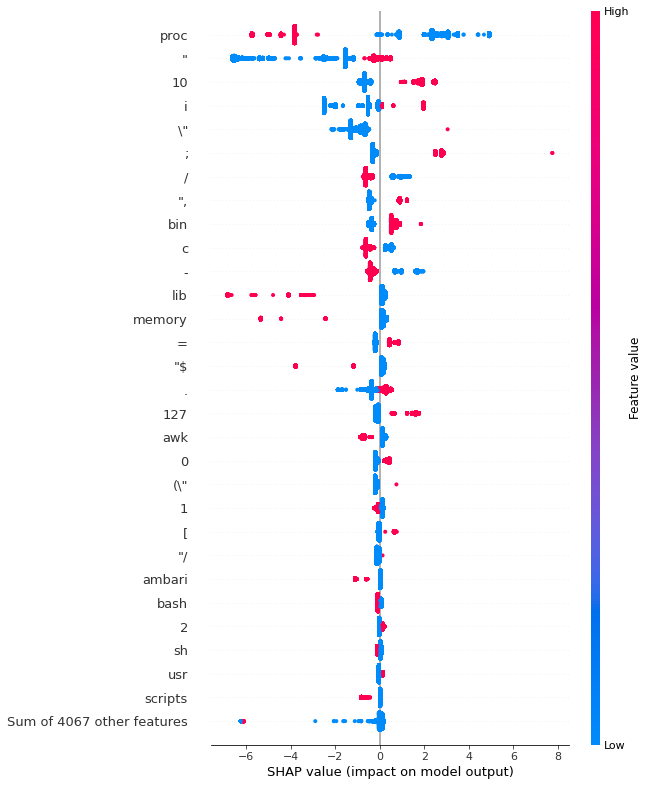

In [140]:
shap.plots.beeswarm(explanations_adv, max_display=30)

In [141]:
mean_shap_values_adv = np.mean(explanations_adv.values, axis=0)

# find top 10 most important features
TOP_HEAVIEST = 15
top_malicious_idx_adv = np.argsort(mean_shap_values_adv)[-TOP_HEAVIEST:][::-1]
top_malicious_features_adv = {features[idx]: round(mean_shap_values_adv[idx], 8) for idx in top_malicious_idx_adv}
print(top_malicious_features_adv)

{';': 0.46462288, '10': 0.41847497, 'bin': 0.22753806, 'awk': 0.03889767, '2': 0.02679778, '1': 0.02613268, '127': 0.0173873, '--': 0.00738265, 'print': 0.00580731, 'tag': 0.00423604, 'sys': 0.00417406, 'sh': 0.002508, 'o': 0.00208827, 'rx': 0.0017526, 'version': 0.00171017}


In [142]:
TOP_LIGHT = 15
top_benign_idx_adv = np.argsort(mean_shap_values_adv)[:TOP_LIGHT]
top_benign_features_adv = {features[idx]: round(mean_shap_values_adv[idx],4) for idx in top_benign_idx_adv}
print(top_benign_features_adv)

{'"': -2.7571, '\\"': -0.9828, 'i': -0.7715, '/': -0.341, '(\\"': -0.1803, '-': -0.1775, 'lib': -0.1321, 'c': -0.1256, '",': -0.1206, 'memory': -0.0814, '"/': -0.0656, '.': -0.0591, '"$': -0.0487, '[': -0.0243, 'ambari': -0.0243}


# Compare `explanations` and `explanations_adv`

Comparing sparse matrices using == is inefficient, try using != instead.


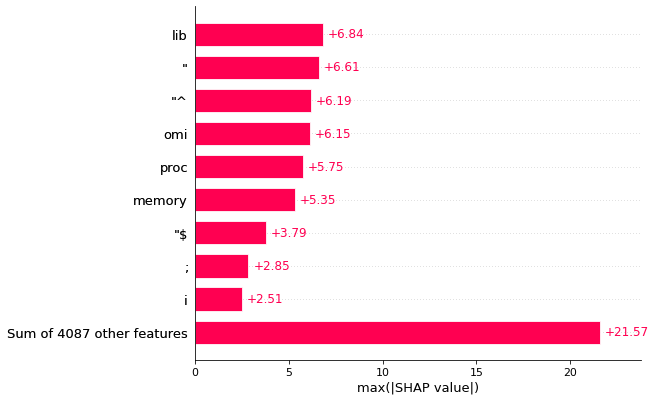

In [144]:
shap.plots.bar(explanations_adv[:1000].abs.max(0))

Comparing sparse matrices using == is inefficient, try using != instead.


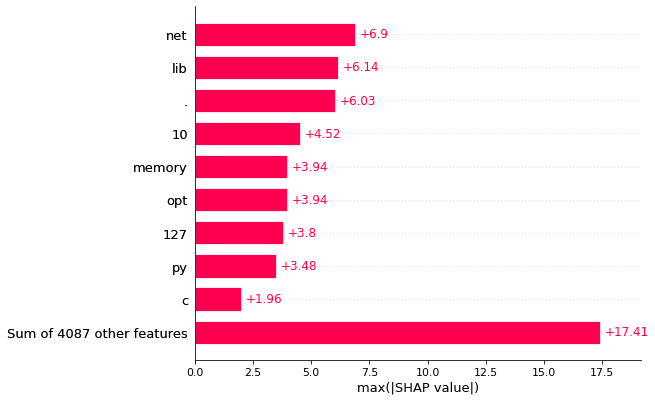

In [145]:
shap.plots.bar(explanations[:1000].abs.max(0))

Comparing sparse matrices using == is inefficient, try using != instead.


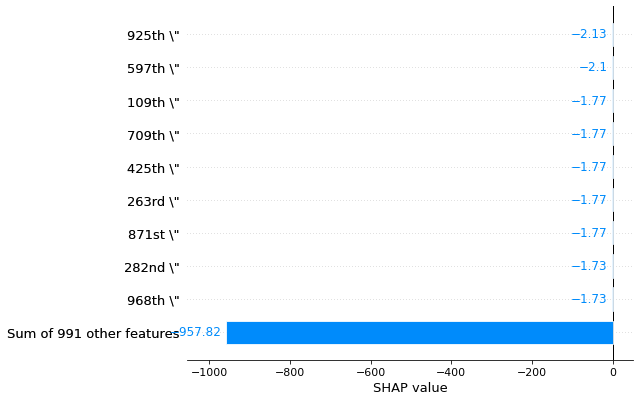

In [147]:
shap.plots.bar(explanations_adv[:1000, r'\"'])

Comparing sparse matrices using == is inefficient, try using != instead.


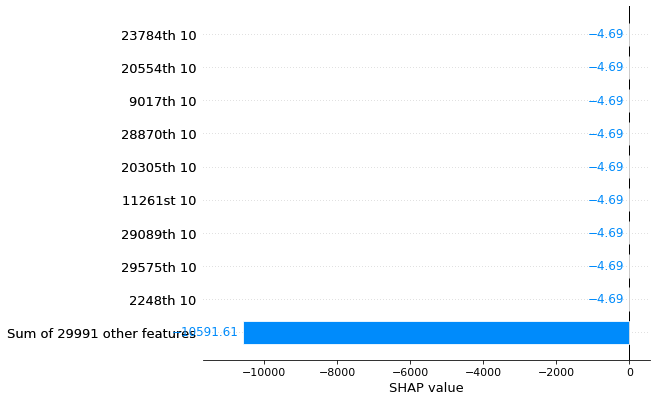

In [138]:
shap.plots.bar(explanations[:1000, "10"])